#### This notebook downloads DEM for each HUC12, and plots them
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [7]:
# Import libraries
import numpy as np
import geopandas as gpd
import os
import time
import requests
import pyproj
import time
import rasterio
from osgeo import gdal
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
from watermark import watermark
from pyproj import CRS
from pathlib import Path
import datetime

# 1-m DEM dateset
United States Geological Survey (2021). United States Geological Survey 3D Elevation Program 1 meter Digital Elevation Model. Distributed by OpenTopography. https://doi.org/10.5069/G98K778D. Accessed: 2025-01-30

# Dataset avialability in NYS

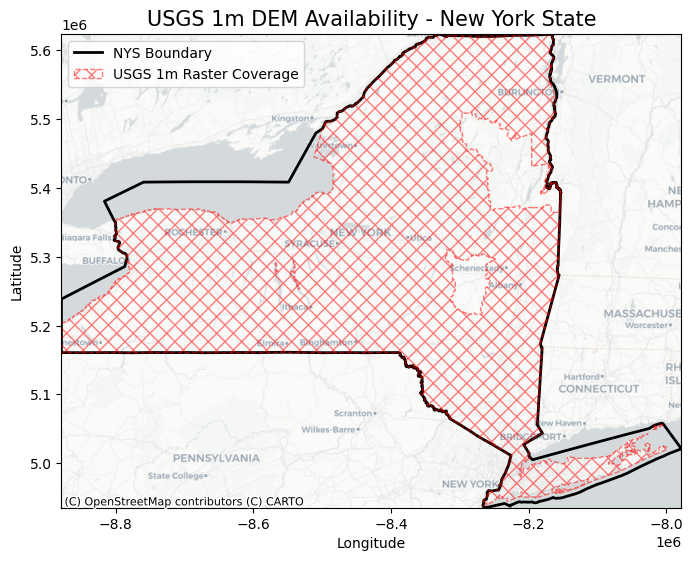

In [2]:
# Load USGS 1m Raster Coverage GeoJSON
url = "https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/OpenTopography_Raster/USGS1m.geojson"
gdf = gpd.read_file(url)

# Load NYS shapefile
base_dir = r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"

# Read and reproject NYS shapefile
state_shapefile = gpd.read_file(state_shapefile_path).to_crs(epsg=3857)

# Reproject USGS raster dataset to match NYS (EPSG:3857 for compatibility with contextily)
gdf = gdf.to_crs(epsg=3857)

# Clip the USGS 1m data to the NYS boundary
gdf_ny = gpd.overlay(gdf, state_shapefile, how="intersection")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the New York State boundary
state_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, linestyle="-", label="NYS Boundary")

# Plot the clipped USGS 1m raster coverage with hatching
gdf_ny.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, linestyle="--", hatch='xx',alpha=0.5, label="USGS 1m Coverage")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_ny.crs)

# Set title
ax.set_title("USGS 1m DEM Availability - New York State", fontsize=15)

# Adjust plot limits to match NYS extent
ax.set_xlim(state_shapefile.total_bounds[0], state_shapefile.total_bounds[2])
ax.set_ylim(state_shapefile.total_bounds[1], state_shapefile.total_bounds[3])

# Axis labels 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Custom legend
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle="-", label="NYS Boundary"),
    Patch(facecolor='none', edgecolor='red', linestyle='--', hatch='xx', alpha=0.5, label="USGS 1m Raster Coverage")
]
ax.legend(handles=legend_elements, loc="upper left")

plt.savefig(r'D:\culvert repo\Results\Figures\USGS_1m_DEM_Coverage_NYS.png', dpi=300)
plt.show()

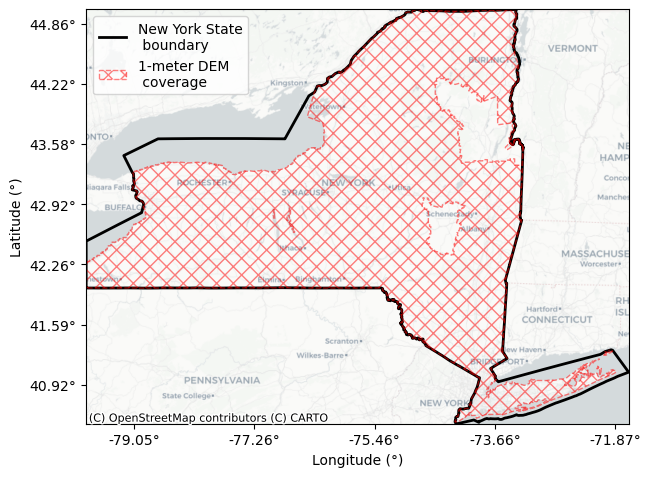

In [16]:
# Load USGS 1m Raster Coverage GeoJSON
url = "https://raw.githubusercontent.com/OpenTopography/Data_Catalog_Spatial_Boundaries/main/OpenTopography_Raster/USGS1m.geojson"
gdf = gpd.read_file(url)

# Load NYS shapefile
base_dir = r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"
state_shapefile = gpd.read_file(state_shapefile_path).to_crs(epsg=3857)

# Reproject USGS raster dataset to match NYS (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# Clip USGS 1m DEM coverage to NYS boundary
gdf_ny = gpd.overlay(gdf, state_shapefile, how="intersection")

# Plot
fig, ax = plt.subplots(figsize=(7, 6))

# Plot NYS boundary
state_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2, linestyle="-", label="New York State\n boundary")

# Plot clipped USGS coverage
gdf_ny.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, linestyle="--", hatch='xx', alpha=0.5, label="1-meter DEM \n Coverage")

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_ny.crs)

# Set plot limits to match NYS extent
ax.set_xlim(state_shapefile.total_bounds[0], state_shapefile.total_bounds[2])
ax.set_ylim(state_shapefile.total_bounds[1], state_shapefile.total_bounds[3])

# Coordinate conversion: EPSG:3857 → EPSG:4326
proj_4326 = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

def format_lon(x, _):
    lon, _ = proj_4326.transform(x, 0)
    return f"{lon:.2f}°"

def format_lat(y, _):
    _, lat = proj_4326.transform(0, y)
    return f"{lat:.2f}°"

# Format axis ticks to 4326
ax.xaxis.set_major_formatter(FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(FuncFormatter(format_lat))

# Axis labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Title
#ax.set_title("USGS 1m DEM Availability - New York State", fontsize=15)

# Custom legend
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle="-", label="New York State\n boundary"),
    Patch(facecolor='none', edgecolor='red', linestyle='--', hatch='xx', alpha=0.5, label="1-meter DEM \n coverage")
]
ax.legend(handles=legend_elements, loc="upper left")

# Save the figure
plt.savefig(r'D:\culvert repo\Results\Figures\USGS_1m_DEM_Coverage_NYS.png', dpi=300)
plt.show()

# Download and save the DEM for each HUC12

In [20]:
%%time 
base_dir=r'D:\culvert repo\Results\Clipped_layers'
#Define layers directories
output_huc12_dir = rf'{base_dir}\clipped_huc12'
output_DEM_dir=rf'{base_dir}\HUC12_one meter_DEM'

# Set the flags
fileone= False
filetwo= False
reproout= False
output_mosaic_flag=False

# Read HUC12 list
file_path = r"D:\culvert repo\Results\Lists\huc12_with_all_layers.txt"
with open(file_path, 'r') as file:
    huc12_with_all_layers = [line.strip() for line in file]
total_hucs=len(huc12_with_all_layers)    
#########################################################################################################################################################
for i, huc in enumerate(huc12_with_all_layers):
    clipped_tiff = fr'{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_DEM.tiff'

    # Check if the file exists; if so, skip to the next iteration
    if os.path.exists(clipped_tiff):
        print(f"File {clipped_tiff} already exists. Skipping...")
        continue
    
    try:
        print(huc)
        # Print the HUC number and the percent of remaining HUCs in this chunk
        remaining_files = total_hucs - (i + 1)
        percent_remaining = (remaining_files / total_hucs) * 100
        print(f"HUC number: {huc}, Percent of remaining files: {percent_remaining:.2f}%")
        # path to the specific HUC layer
        output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
        huc12 = gpd.read_file(output_huc12_path)
#########################################################################################################################################################
        # Define a bounding box over the HUC
        huc12 = huc12.to_crs(epsg=4326)
        minx, miny, maxx, maxy = huc12.bounds['minx'][0], huc12.bounds['miny'][0], huc12.bounds['maxx'][0], huc12.bounds['maxy'][0]
        # API call
        url = 'https://portal.opentopography.org/API/usgsdem'
        params = {
            'datasetName': 'USGS1m',
            'south': miny,
            'north': maxy,
            'west': minx,
            'east': maxx,
            'outputFormat': 'GTiff',
            #'API_Key': enter the API key from opentopography
        }
        headers = {
            'accept': '*/*'
        }
        
        # Directory to save the downloaded DEMs
        output_DEM_dir = fr'{base_dir}\HUC12_one meter_DEM\{huc}'
        if not os.path.exists(output_DEM_dir):
            os.makedirs(output_DEM_dir)
        
        # Function to download DEM
        def download_dem(west, east, filename):
            for attempt in range(3):
                params.update({'south': miny, 'north': maxy, 'west': west, 'east': east})
                response = requests.get(url, params=params, headers=headers)
                
                if response.status_code == 200:
                    file_path = f'{output_DEM_dir}/{filename}.tiff'
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f'File {filename} downloaded successfully and saved to {file_path}.')
                    return file_path
                elif response.status_code == 400:
                    print(f"400 Bad Request for {filename}. Splitting the bounding box and retrying.")
                    return None
                else:
                    print(f"Attempt {attempt + 1}: Failed to retrieve data - Status code: {response.status_code}")
                    if attempt < 2:
                        time.sleep(5)  # Wait for 5 seconds before retrying
                    else:
                        print(f"Failed to download {filename} after 3 attempts.")
                        return None
        
        # First attempt to download the DEM
        file_path = download_dem(minx, maxx, f'{huc}')
        
        # If 400 error occurs, download two DEMs by splitting the bounding box
        if file_path is None:
            midx = (minx + maxx) / 2
            file1 = download_dem(minx, midx+((maxx-minx)*0.1), f'{huc}_west')
            fileone= True
            file2 = download_dem(midx-((maxx-minx)*0.1), maxx, f'{huc}_east')
            filetwo= True
            with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
                # Check if both files were downloaded successfully
                if file1 and file2:
    
                    input_files = [file1, file2]
                    
                    # Define output file paths
                    output_mosaic = fr"{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_east_west_mosaic.tiff"
                    reprojected_output = fr"{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_mosaic_reprojected.tiff"

                    # Mosaic the input files
                    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
                    mosaic_vrt = gdal.BuildVRT('mosaic.vrt', input_files, options=vrt_options)

                    # Check if the VRT was created successfully
                    if mosaic_vrt is None:
                        raise ValueError("Failed to create the VRT mosaic.")
                        
                    # Convert the VRT to a GeoTIFF
                    translated = gdal.Translate(output_mosaic, mosaic_vrt)
                    output_mosaic_flag = True
                    if translated is None:
                        raise ValueError("Failed to translate the VRT to a GeoTIFF.")
                    # Reproject the mosaic to the target CRS (NAD_1983_UTM)
                    target_crs = 'EPSG:4326'  # Replace with the correct EPSG code for your UTM zone
                    warp_options = gdal.WarpOptions(dstSRS=target_crs)
                    warped = gdal.Warp(reprojected_output, output_mosaic, options=warp_options)
                    file_path=reprojected_output
                    reproout= True
                    #close
                    warped= None
                    mosaic_vrt=None  
                    translated=None
                else:
                    print("Failed to download one or both of the DEMs, cannot proceed with mosaicing.")
            src1.close()
            src2.close()
#########################################################################################################################################################
        #reproject the temporary tiff from 4326 to 5070
        output_tiff=fr'{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_5070.tiff'
        
        # Define source and target CRS
        src_crs = CRS.from_epsg(4326)  # Original CRS (EPSG:4326)
        dst_crs = CRS.from_epsg(5070)  # Target CRS (EPSG:5070)
        
        # Open the source raster
        with rasterio.open(file_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
        
            # Reproject and save to the output file
            with rasterio.open(output_tiff, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
#########################################################################################################################################################
        # Clip and save the final reprojected DEM
        clipped_tiff_dir = fr'{base_dir}\HUC12_one meter_DEM\{huc}'
        huc12 = huc12.to_crs(epsg=5070)
        # Path file
        clipped_tiff = os.path.join(clipped_tiff_dir, f'{huc}_DEM.tiff')
    
        # Convert the HUC12 boundary to GeoJSON-like format
        huc12_geom = [feature["geometry"] for feature in huc12.__geo_interface__["features"]]
    
        # Open the reprojected TIFF file and clip it using the HUC12 boundary
        with rasterio.open(output_tiff) as src:
            out_image, out_transform = mask(src, huc12_geom, crop=True)
            out_image[out_image == src.nodata] = -99999  # Set NoData value
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "crs": src.crs,
                "nodata": -99999
            })
    
            # Save the clipped DEM to a new file
            with rasterio.open(clipped_tiff, 'w', **out_meta) as dst:
                dst.write(out_image)
        src.close()
#########################################################################################################################################################
        #Remove other files
        if fileone: 
            fileone= False
            try:
                os.remove(file1)
                print(f"{file1} removed successfully.")
            except FileNotFoundError:
                print(f"{file1} does not exist.") 
                
        if filetwo: 
            filetwo= False
            try:
                os.remove(file2)
                print(f"{file2} removed successfully.")
            except FileNotFoundError:
                print(f"{file2} does not exist.")   
            del file2
                
        file=f'{output_DEM_dir}\\{huc}.tiff'
        if  os.path.exists(file):
            try:
                os.remove(file)
                print(f"{file} removed successfully.")
            except FileNotFoundError:
                print(f"{file} does not exist.")  
            del file
        
     
        try:
            os.remove(output_tiff)
            print(f"{output_tiff} removed successfully.")
        except FileNotFoundError:
            print(f"{output_tiff} does not exist.")  
            del output_tiff

        
        if reproout:
            reproout=False
            try:
                os.remove(reprojected_output)
                print(f"{reprojected_output} removed successfully.")
            except FileNotFoundError:
                print(f"{reprojected_output} does not exist.")  
            del reprojected_output

        if output_mosaic_flag:
            output_mosaic_flag=False
            try:
                os.remove(output_mosaic)
                print(f"{output_mosaic} removed successfully.")
            except FileNotFoundError:
                print(f"{output_mosaic} does not exist.")  
            del output_mosaic
#########################################################################################################################################################
    except Exception as e:
        print(f"Failed to analyse HUC {huc}. Error: {e}")

File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\050100020104\050100020104_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\041201010101\041201010101_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020202\020302020202_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020205\020302020205_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020207\020302020207_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020303\020302020303_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020304\020302020304_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020402\020302020402_DEM.tiff already exis

In [22]:
# Report percent of HUC12s with 1-meter DEM
onemeterdem_count=0
for i, huc in enumerate(huc12_with_all_layers):
    clipped_tiff = fr'{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_DEM.tiff'
    if os.path.exists(clipped_tiff):
        onemeterdem_count+=1
        continue
print(f'Percent of huc12s with 1-meter dem is {onemeterdem_count/len(huc12_with_all_layers)* 100:.2f}  %')

Percent of huc12s with 1-meter dem is 95.71  %


#### If the 1-meter dem is not available then download 10-m DEM

In [23]:
%%time 
base_dir=r'D:\culvert repo\Results\Clipped_layers'
#Define layers directories
output_huc12_dir = rf'{base_dir}\clipped_huc12'
output_DEM_dir=rf'{base_dir}\HUC12_one meter_DEM'

# SET THE FLAGS
fileone= False
filetwo= False
reproout= False
output_mosaic_flag=False

# Read HUC12 list
file_path = r"D:\culvert repo\Results\Lists\huc12_with_all_layers.txt"
with open(file_path, 'r') as file:
    huc12_with_all_layers = [line.strip() for line in file]
total_hucs=len(huc12_with_all_layers)    
#########################################################################################################################################################
for i, huc in enumerate(huc12_with_all_layers):
    clipped_tiff = fr'{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_DEM.tiff'

    # Check if the file exists; if so, skip to the next iteration
    if os.path.exists(clipped_tiff):
        print(f"File {clipped_tiff} already exists. Skipping...")
        continue
    
    try:
        print(huc)
        # Print the HUC number and the percent of remaining HUCs in this chunk
        remaining_files = total_hucs - (i + 1)
        percent_remaining = (remaining_files / total_hucs) * 100
        print(f"HUC number: {huc}, Percent of remaining files: {percent_remaining:.2f}%")
        # path to the specific HUC layer
        output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
        huc12 = gpd.read_file(output_huc12_path)
#########################################################################################################################################################
        # Define a bounding box over the HUC
        huc12 = huc12.to_crs(epsg=4326)
        minx, miny, maxx, maxy = huc12.bounds['minx'][0], huc12.bounds['miny'][0], huc12.bounds['maxx'][0], huc12.bounds['maxy'][0]
        
        url = 'https://portal.opentopography.org/API/usgsdem'
        params = {
            'datasetName': 'USGS10m',
            'south': miny,
            'north': maxy,
            'west': minx,
            'east': maxx,
            'outputFormat': 'GTiff',
            #'API_Key': Enter the key from opentopography 
        }
        headers = {
            'accept': '*/*'
        }
        
        # Directory to save the downloaded DEMs
        output_DEM_dir = fr'{base_dir}\HUC12_one meter_DEM\{huc}'
        if not os.path.exists(output_DEM_dir):
            os.makedirs(output_DEM_dir)
        
        # Function to download DEM
        def download_dem(west, east, filename):
            for attempt in range(3):
                params.update({'south': miny, 'north': maxy, 'west': west, 'east': east})
                response = requests.get(url, params=params, headers=headers)
                
                if response.status_code == 200:
                    file_path = f'{output_DEM_dir}/{filename}.tiff'
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f'File {filename} downloaded successfully and saved to {file_path}.')
                    return file_path
                elif response.status_code == 400:
                    print(f"400 Bad Request for {filename}. Splitting the bounding box and retrying.")
                    return None
                else:
                    print(f"Attempt {attempt + 1}: Failed to retrieve data - Status code: {response.status_code}")
                    if attempt < 2:
                        time.sleep(5)  # Wait for 5 seconds before retrying
                    else:
                        print(f"Failed to download {filename} after 3 attempts.")
                        return None
        
        # First attempt to download the DEM
        file_path = download_dem(minx, maxx, f'{huc}')
        
        # If 400 error occurs, download two DEMs by splitting the bounding box
        if file_path is None:
            midx = (minx + maxx) / 2
            file1 = download_dem(minx, midx+((maxx-minx)*0.1), f'{huc}_west')
            fileone= True
            file2 = download_dem(midx-((maxx-minx)*0.1), maxx, f'{huc}_east')
            filetwo= True
            with rasterio.open(file1) as src1, rasterio.open(file2) as src2:
                # Check if both files were downloaded successfully
                if file1 and file2:
    
                    input_files = [file1, file2]
                    
                    # Define output file paths
                    output_mosaic = fr"{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_east_west_mosaic.tiff"
                    reprojected_output = fr"{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_mosaic_reprojected.tiff"

                    # Mosaic the input files
                    vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')
                    mosaic_vrt = gdal.BuildVRT('mosaic.vrt', input_files, options=vrt_options)

                    # Check if the VRT was created successfully
                    if mosaic_vrt is None:
                        raise ValueError("Failed to create the VRT mosaic.")
                        
                    # Convert the VRT to a GeoTIFF
                    translated = gdal.Translate(output_mosaic, mosaic_vrt)
                    output_mosaic_flag = True
                    if translated is None:
                        raise ValueError("Failed to translate the VRT to a GeoTIFF.")
                    # Reproject the mosaic to the target CRS (NAD_1983_UTM)
                    target_crs = 'EPSG:4326'  # Replace with the correct EPSG code for your UTM zone
                    warp_options = gdal.WarpOptions(dstSRS=target_crs)
                    warped = gdal.Warp(reprojected_output, output_mosaic, options=warp_options)
                    file_path=reprojected_output
                    reproout= True
                    #close
                    warped= None
                    mosaic_vrt=None  
                    translated=None
                else:
                    print("Failed to download one or both of the DEMs, cannot proceed with mosaicing.")
            src1.close()
            src2.close()
#########################################################################################################################################################
        #reproject the temporary tiff from 4326 to 5070
        output_tiff=fr'{base_dir}\HUC12_one meter_DEM\{huc}\{huc}_5070.tiff'
        
        # Define source and target CRS
        src_crs = CRS.from_epsg(4326)  # Original CRS (EPSG:4326)
        dst_crs = CRS.from_epsg(5070)  # Target CRS (EPSG:5070)
        
        # Open the source raster
        with rasterio.open(file_path) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })
        
            # Reproject and save to the output file
            with rasterio.open(output_tiff, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
#########################################################################################################################################################
        # Clip and save the final reprojected DEM
        clipped_tiff_dir = fr'{base_dir}\HUC12_one meter_DEM\{huc}'
        huc12 = huc12.to_crs(epsg=5070)
        # Path file
        clipped_tiff = os.path.join(clipped_tiff_dir, f'{huc}_DEM.tiff')
    
        # Convert the HUC12 boundary to GeoJSON-like format
        huc12_geom = [feature["geometry"] for feature in huc12.__geo_interface__["features"]]
    
        # Open the reprojected TIFF file and clip it using the HUC12 boundary
        with rasterio.open(output_tiff) as src:
            out_image, out_transform = mask(src, huc12_geom, crop=True)
            out_image[out_image == src.nodata] = -99999  # Set NoData value
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "crs": src.crs,
                "nodata": -99999
            })
    
            # Save the clipped DEM to a new file
            with rasterio.open(clipped_tiff, 'w', **out_meta) as dst:
                dst.write(out_image)
        src.close()
#########################################################################################################################################################
        #Remove other files
        if fileone: 
            fileone= False
            try:
                os.remove(file1)
                print(f"{file1} removed successfully.")
            except FileNotFoundError:
                print(f"{file1} does not exist.") 
                
        if filetwo: 
            filetwo= False
            try:
                os.remove(file2)
                print(f"{file2} removed successfully.")
            except FileNotFoundError:
                print(f"{file2} does not exist.")   
            del file2
                
        file=f'{output_DEM_dir}\\{huc}.tiff'
        if  os.path.exists(file):
            try:
                os.remove(file)
                print(f"{file} removed successfully.")
            except FileNotFoundError:
                print(f"{file} does not exist.")  
            del file
        
        try:
            os.remove(output_tiff)
            print(f"{output_tiff} removed successfully.")
        except FileNotFoundError:
            print(f"{output_tiff} does not exist.")  
            del output_tiff

        if reproout:
            reproout=False
            try:
                os.remove(reprojected_output)
                print(f"{reprojected_output} removed successfully.")
            except FileNotFoundError:
                print(f"{reprojected_output} does not exist.")  
            del reprojected_output

        if output_mosaic_flag:
            output_mosaic_flag=False
            try:
                os.remove(output_mosaic)
                print(f"{output_mosaic} removed successfully.")
            except FileNotFoundError:
                print(f"{output_mosaic} does not exist.")  
            del output_mosaic
#########################################################################################################################################################
    except Exception as e:
        print(f"Failed to analyse HUC {huc}. Error: {e}")

File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\050100020104\050100020104_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\041201010101\041201010101_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020202\020302020202_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020205\020302020205_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020207\020302020207_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020303\020302020303_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020304\020302020304_DEM.tiff already exists. Skipping...
File D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\020302020402\020302020402_DEM.tiff already exis

# Visualization

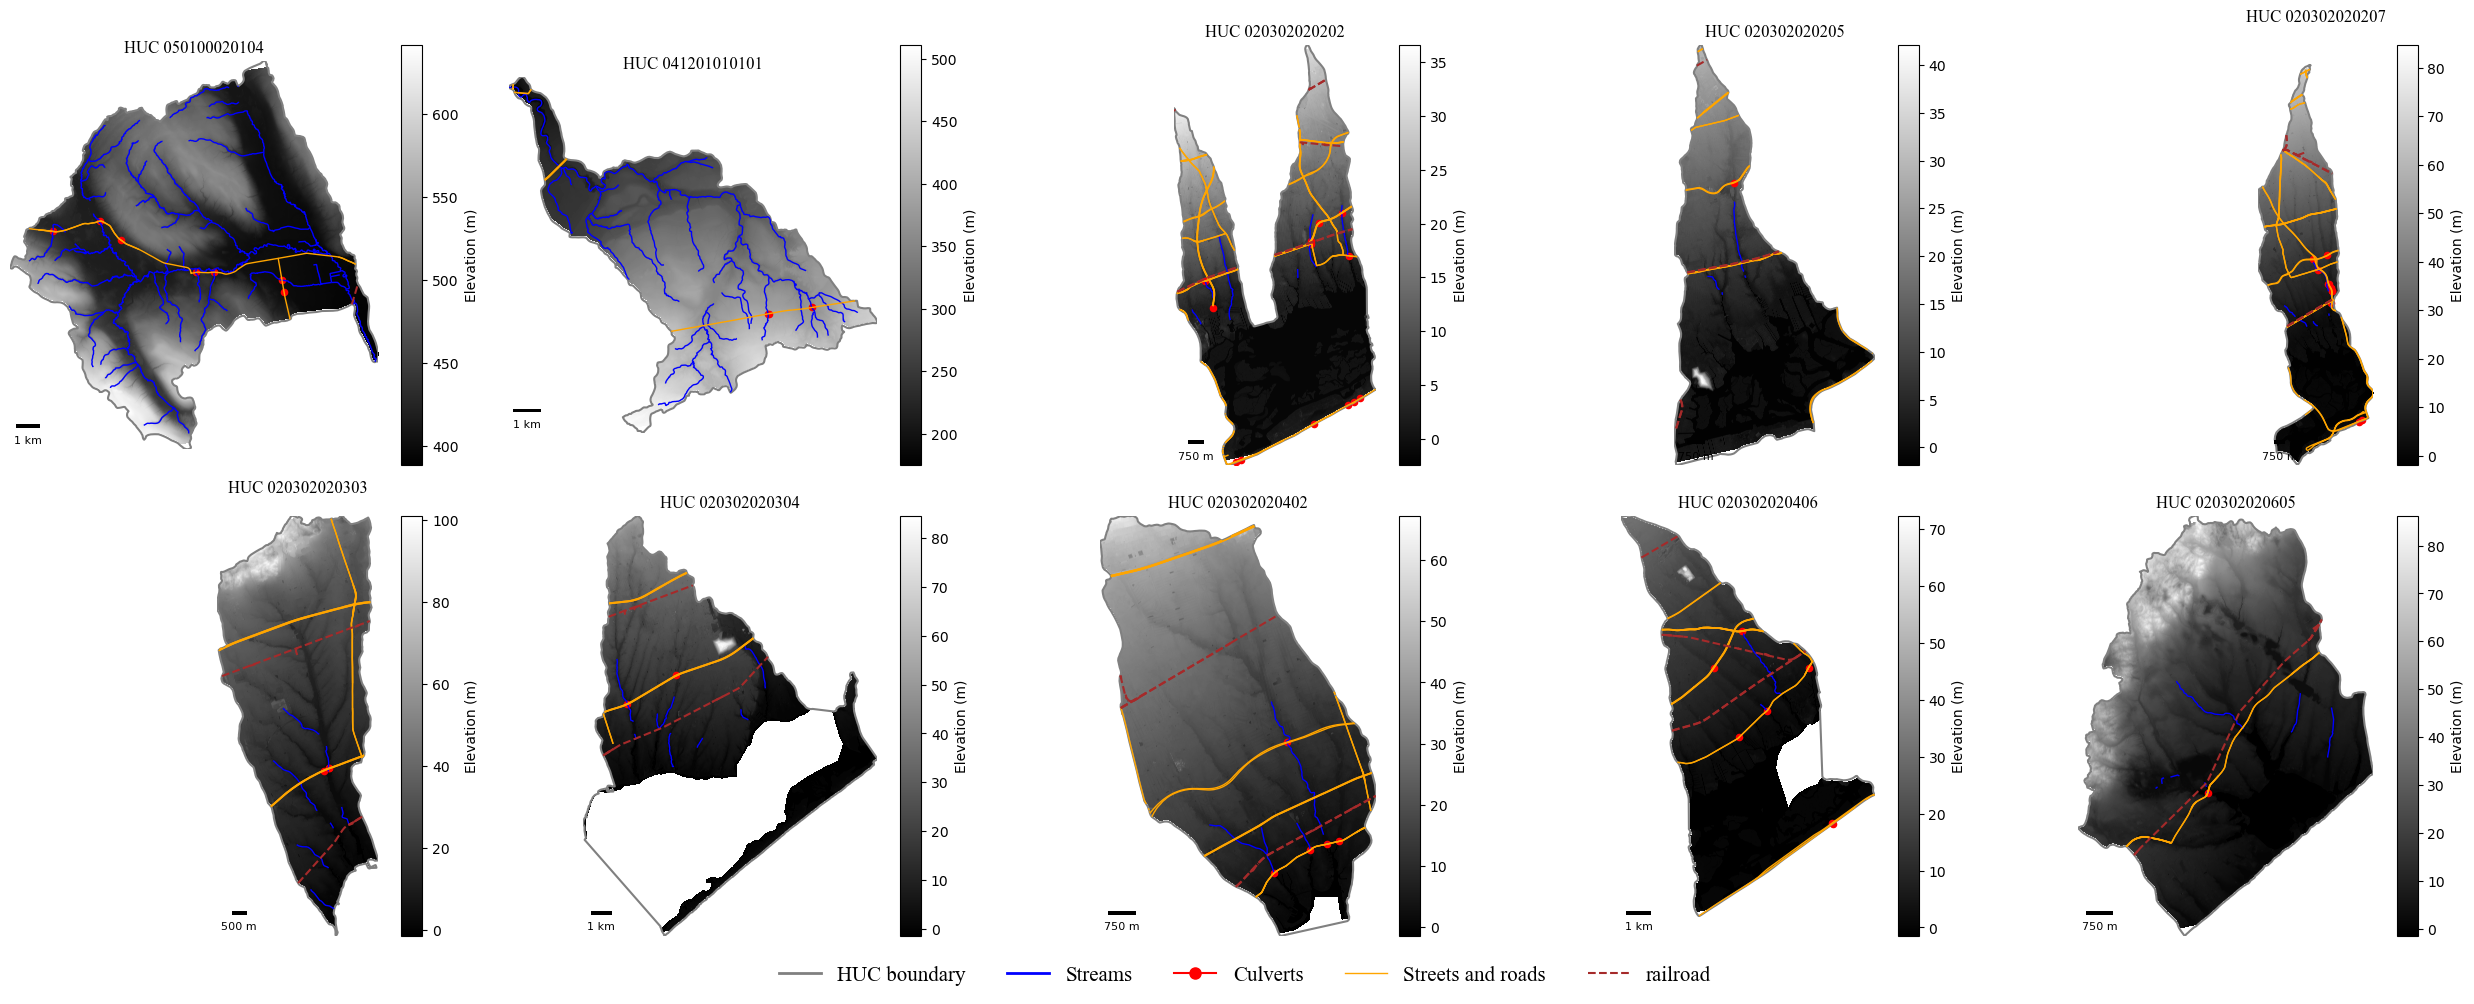

CPU times: total: 11min 12s
Wall time: 11min 47s


In [39]:
%%time
# Select 10 HUCs
selected_hucs = huc12_with_all_layers[:10]

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns

# Define legend elements
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=2, label='HUC boundary'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Streams'),
    plt.Line2D([0], [0], marker='o', color='red', markersize=10, label='Culverts'),
    plt.Line2D([0], [0], color='orange', lw=1, label='Streets and roads'),
    plt.Line2D([0], [0], color='brown', lw=1.5, linestyle='dashed', label='railroad')
]

for ax, huc in zip(axes.flat, selected_hucs):
    # Define paths
    output_huc12_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_huc12', f'{huc}_huc12.shp')
    output_stream_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_streams', f'{huc}_streams.shp')
    output_road_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_street', f'{huc}_streets.shp')
    output_culvert_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_culverts', f'{huc}_culverts.shp')
    clipped_tiff = os.path.join(rf'D:\culvert repo\Results\Clipped_layers\HUC12_one meter_DEM\{huc}', f'{huc}_DEM.tiff')
    output_railroad_path = os.path.join(r'D:\culvert repo\Results\Clipped_layers\clipped_railroad', f'{huc}_railroads.shp')
    
    # Read and plot DEM
    with rasterio.open(clipped_tiff) as dem:
        dem_data = dem.read(1).astype(float)
        dem_data[dem_data == -99999] = np.nan
        dem_bounds = dem.bounds
        # Plot DEM
        im = ax.imshow(dem_data, cmap='gray', extent=(dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top))
    
    # Overlay shapefiles
    gpd.read_file(output_huc12_path).boundary.plot(ax=ax, edgecolor='gray', linewidth=1.5) # HUC12
    gpd.read_file(output_stream_path).plot(ax=ax, color='blue', linewidth=1) 
    gpd.read_file(output_culvert_path).plot(ax=ax, color='red', markersize=20)
    gpd.read_file(output_road_path).plot(ax=ax, color='orange', linewidth=1)
    if os.path.exists(output_railroad_path):
        gpd.read_file(output_railroad_path).plot(ax=ax, color='brown', linewidth=1.5,linestyle='dashed')
    
    # Add scale bar
    scalebar = ScaleBar(1, units='m', dimension='si-length', location='lower left',
                        length_fraction=0.1, font_properties={'size': 8}, frameon=False)
    ax.add_artist(scalebar)
    
    # Add title
    ax.set_title(f'HUC {huc}', fontsize=12, fontname='Times New Roman')
    
    # Hide axis
    ax.set_axis_off()
    # Add colorbar to each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Elevation (m)')

# Add unified legend
fig.legend(
    handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5, prop={'family': 'Times New Roman', 'size': 15},
    markerscale=0.8, frameon=False )

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
plt.savefig(r'D:\culvert repo\Results\Figures\DEM_All_layers_combined_10huc.png', dpi=300, bbox_inches="tight")
plt.show()

In [37]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-01-30 15:21:08.823642


In [38]:
%load_ext watermark
# Print Python version and some dependencies
%watermark -v -m -p numpy,geopandas,rasterio,osgeo,pyproj,matplotlib,contextily

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
geopandas : 1.0.1
rasterio  : 1.3.10
osgeo     : 3.9.2
pyproj    : 3.6.1
matplotlib: 3.8.4
contextily: 1.6.1

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

